[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ClimateMatchAcademy/course-content/blob/main/tutorials/W1D3_RemoteSensingLandOceanandAtmosphere/W1D3_Tutorial7.ipynb) &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/tutorials/W1D3_RemoteSensingLandOceanandAtmosphere/W1D3_Tutorial7.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 7: Impact of Climate Variability - Precipitation

**Week 1, Day 3, Remote Sensing**

**Content creators:** Douglas Rao

**Content reviewers:** Katrina Dobson, Younkap Nina Duplex, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Jenna Pearson, Agustina Pesce, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS and Google DeepMind

# Tutorial Objectives

In this tutorial, the primary goal is to understand how to utilize satellite data to investigate the effects of large-scale climate variability on precipitation.

Upon the completion of this tutorial, you will be able to:

- Comprehend the influence of the El Niño-Southern Oscillation (ENSO) on precipitation and its geographical distribution.
- Compute Pearson's correlation coefficient, a statistical measure used to determine the relationship between two time series.


# Setup

In [22]:
# installations ( uncomment and run this cell ONLY when using google colab or kaggle )

# # properly install cartopy in colab to avoid session crash
# !apt-get install libproj-dev proj-data proj-bin --quiet
# !apt-get install libgeos-dev --quiet
# !pip install cython --quiet
# !pip install cartopy --quiet

# !apt-get -qq install python-cartopy python3-cartopy  --quiet
# !pip uninstall -y shapely  --quiet
# !pip install shapely --no-binary shapely  --quiet

# !pip install boto3 --quiet

# you may need to restart the runtime after running this cell and that is ok

In [23]:
# imports
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import os
import requests
import pooch
import tempfile
from scipy import stats

In [24]:
# @title Figure settings
import ipywidgets as widgets  # interactive display

%config InlineBackend.figure_format = 'retina'
plt.style.use(
    "https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle"
)

In [25]:
# @title Helper functions

def pooch_load(filelocation=None, filename=None, processor=None):
    shared_location = "/home/jovyan/shared/data/tutorials/W1D3_RemoteSensingLandOceanandAtmosphere"  # this is different for each day
    user_temp_cache = tempfile.gettempdir()

    if os.path.exists(os.path.join(shared_location, filename)):
        file = os.path.join(shared_location, filename)
    else:
        file = pooch.retrieve(
            filelocation,
            known_hash=None,
            fname=os.path.join(user_temp_cache, filename),
            processor=processor,
        )

    return file

In [26]:
# @title Video 1: Impact of Climate Variability

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'TJr_nNP87Rg'), ('Bilibili', 'BV1Th4y1j7sY')]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [27]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today
from IPython.display import IFrame
link_id = "tyjwu"

# Section 1: ENSO and precipitation

As discussed in previous tutorials, ENSO oscillates irregularly between El Niño and La Niña phases every two to seven years. These shifts often prompt predictable changes in ocean surface temperature and disrupt wind and rainfall patterns across the tropics, leading to a cascade of global side effects.

In this context, we will be utilizing satellite data to scrutinize the influence of ENSO on precipitation patterns. 

## Section 1.1: Get ENSO Index Oceanic Niño Index (ONI)

In last tutorial, we generated the Oceanic Niño Index (ONI) using the OISST Climate Data Records. Now we just read the ONI value using the climatology of 1982-2011.


In [28]:
# download't6_oceanic-nino-index.nc'

url_nino = "https://osf.io/8rwxb/download/"
filename_nino = "t6_oceanic-nino-index"
oni = xr.open_dataset(pooch_load(filelocation=url_nino, filename=filename_nino))
oni

<xarray.Dataset>
Dimensions:  (time: 499)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2023-03-01
    month    (time) int32 ...
Data variables:
    sst      (time) float32 ...

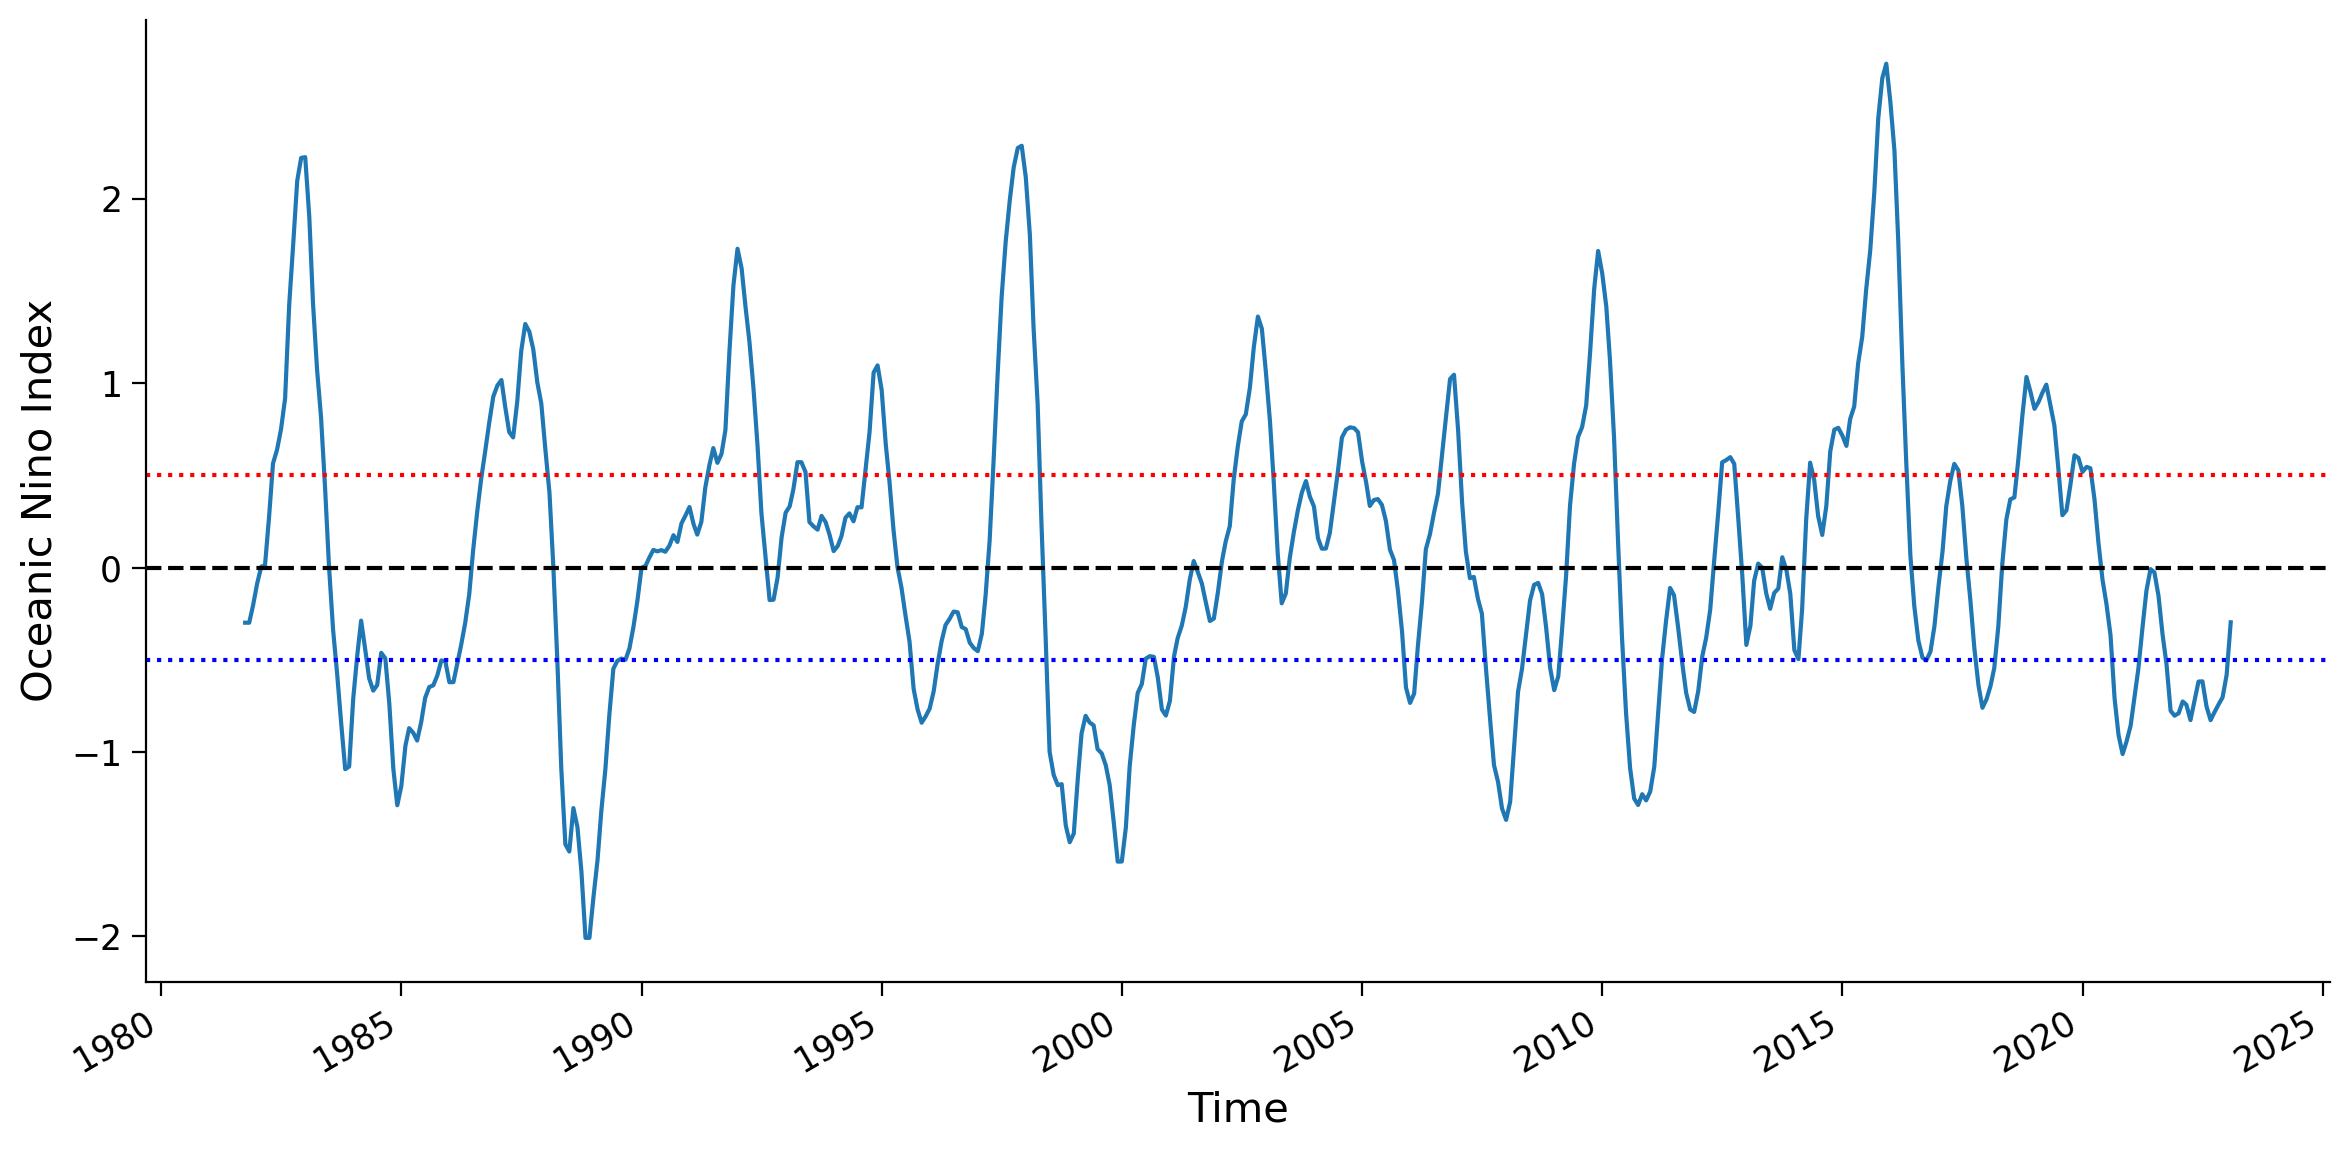

In [29]:
# plot the oni timeseries we just downloaded
fig, ax = plt.subplots(figsize=(12, 6))
oni.sst.plot(ax=ax)
ax.set_ylabel("Oceanic Nino Index")
ax.axhline(y=0, linestyle="dashed", color="k")
ax.axhline(y=0.5, linestyle="dotted", color="r")
ax.axhline(y=-0.5, linestyle="dotted", color="b")

## Section 1.2: Get Precipitation Anomaly Data

In tutorial 5, we created the monthly anomaly data of precipitation globally using the GPCP Monthly Precipitation Climate Data Records. Here, we read in the anomaly data and look at one specific month (e.g., 1998-01-01).

In [30]:
# download file 't5_gpcp-monthly-anomaly_1981-2010.nc'
url_precip = "https://osf.io/vhdcg/download/"
filename_precip = "t5_gpcp-monthly-anomaly_1981-2010.nc"
precip = xr.open_dataset(pooch_load(filelocation=url_precip, filename=filename_precip))
precip

<xarray.Dataset>
Dimensions:    (time: 528, latitude: 72, longitude: 144)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-12-01
    month      (time) int32 ...
  * longitude  (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
Data variables:
    precip     (time, latitude, longitude) float32 ...

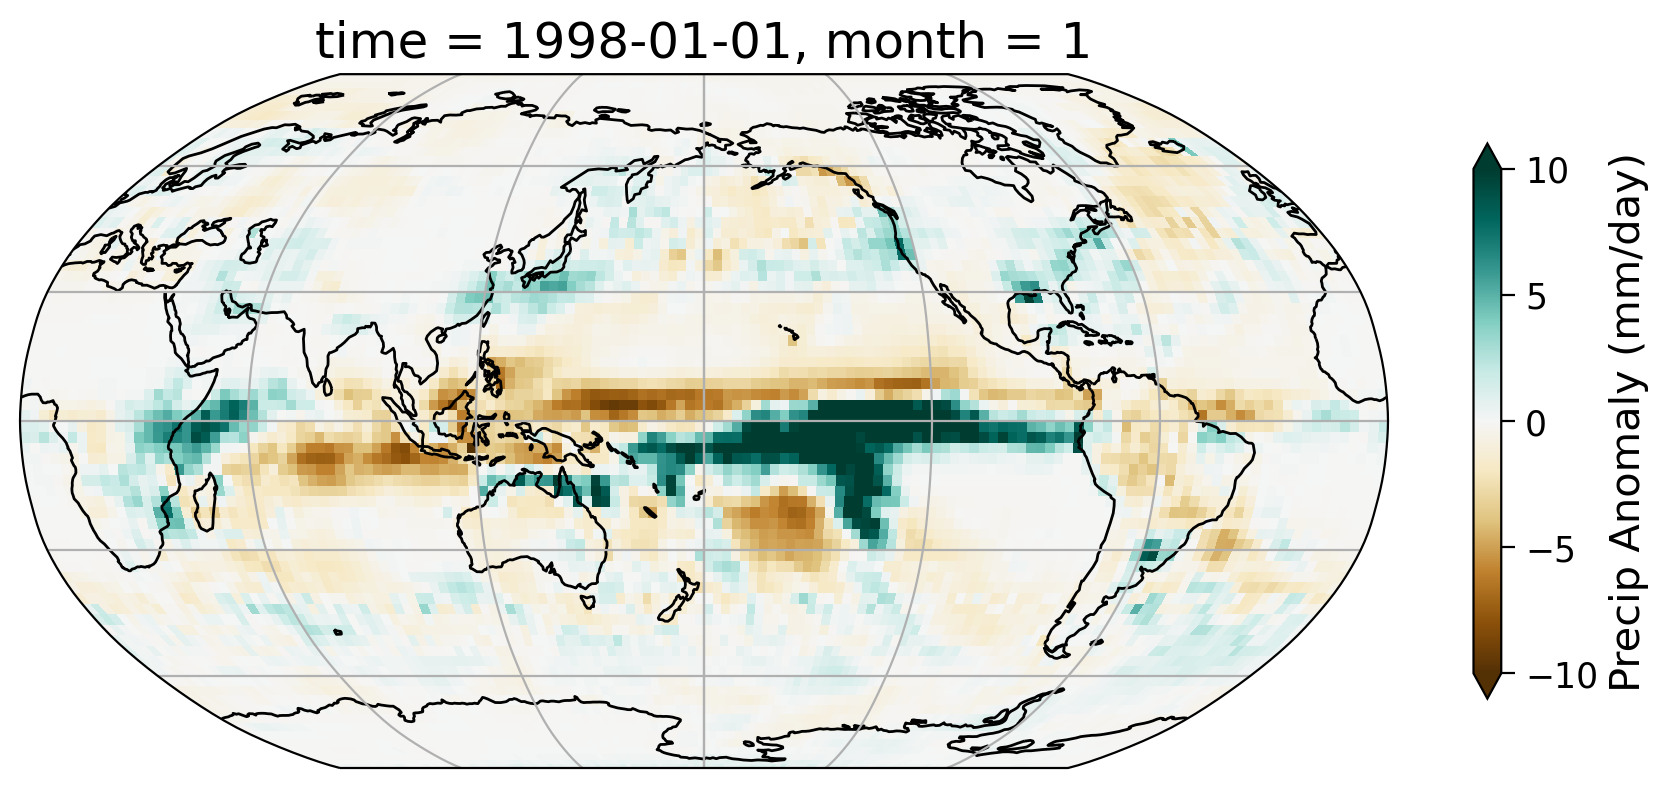

In [31]:
# select just data from 1998
data = precip.sel(time="1998-01-01")

# initate plot
fig = plt.figure(figsize=(9, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.coastlines()
ax.gridlines()
data.precip.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    vmin=-10,
    vmax=10,
    cmap="BrBG",
    cbar_kwargs=dict(shrink=0.5, label="Precip Anomaly (mm/day)"),
)

## Section 1.3: Spatial Pattern

Let's look at one specific ENSO event - the **1997/1998 El Niño** and see how the spatial pattern of the precipitation evolves. The 1997/1998 El Niño is one of the most significant ENSO events that started in May of 1997 and ended April of 1998.

Let's examine the seasonal precipitation anomaly pattern during this time period.

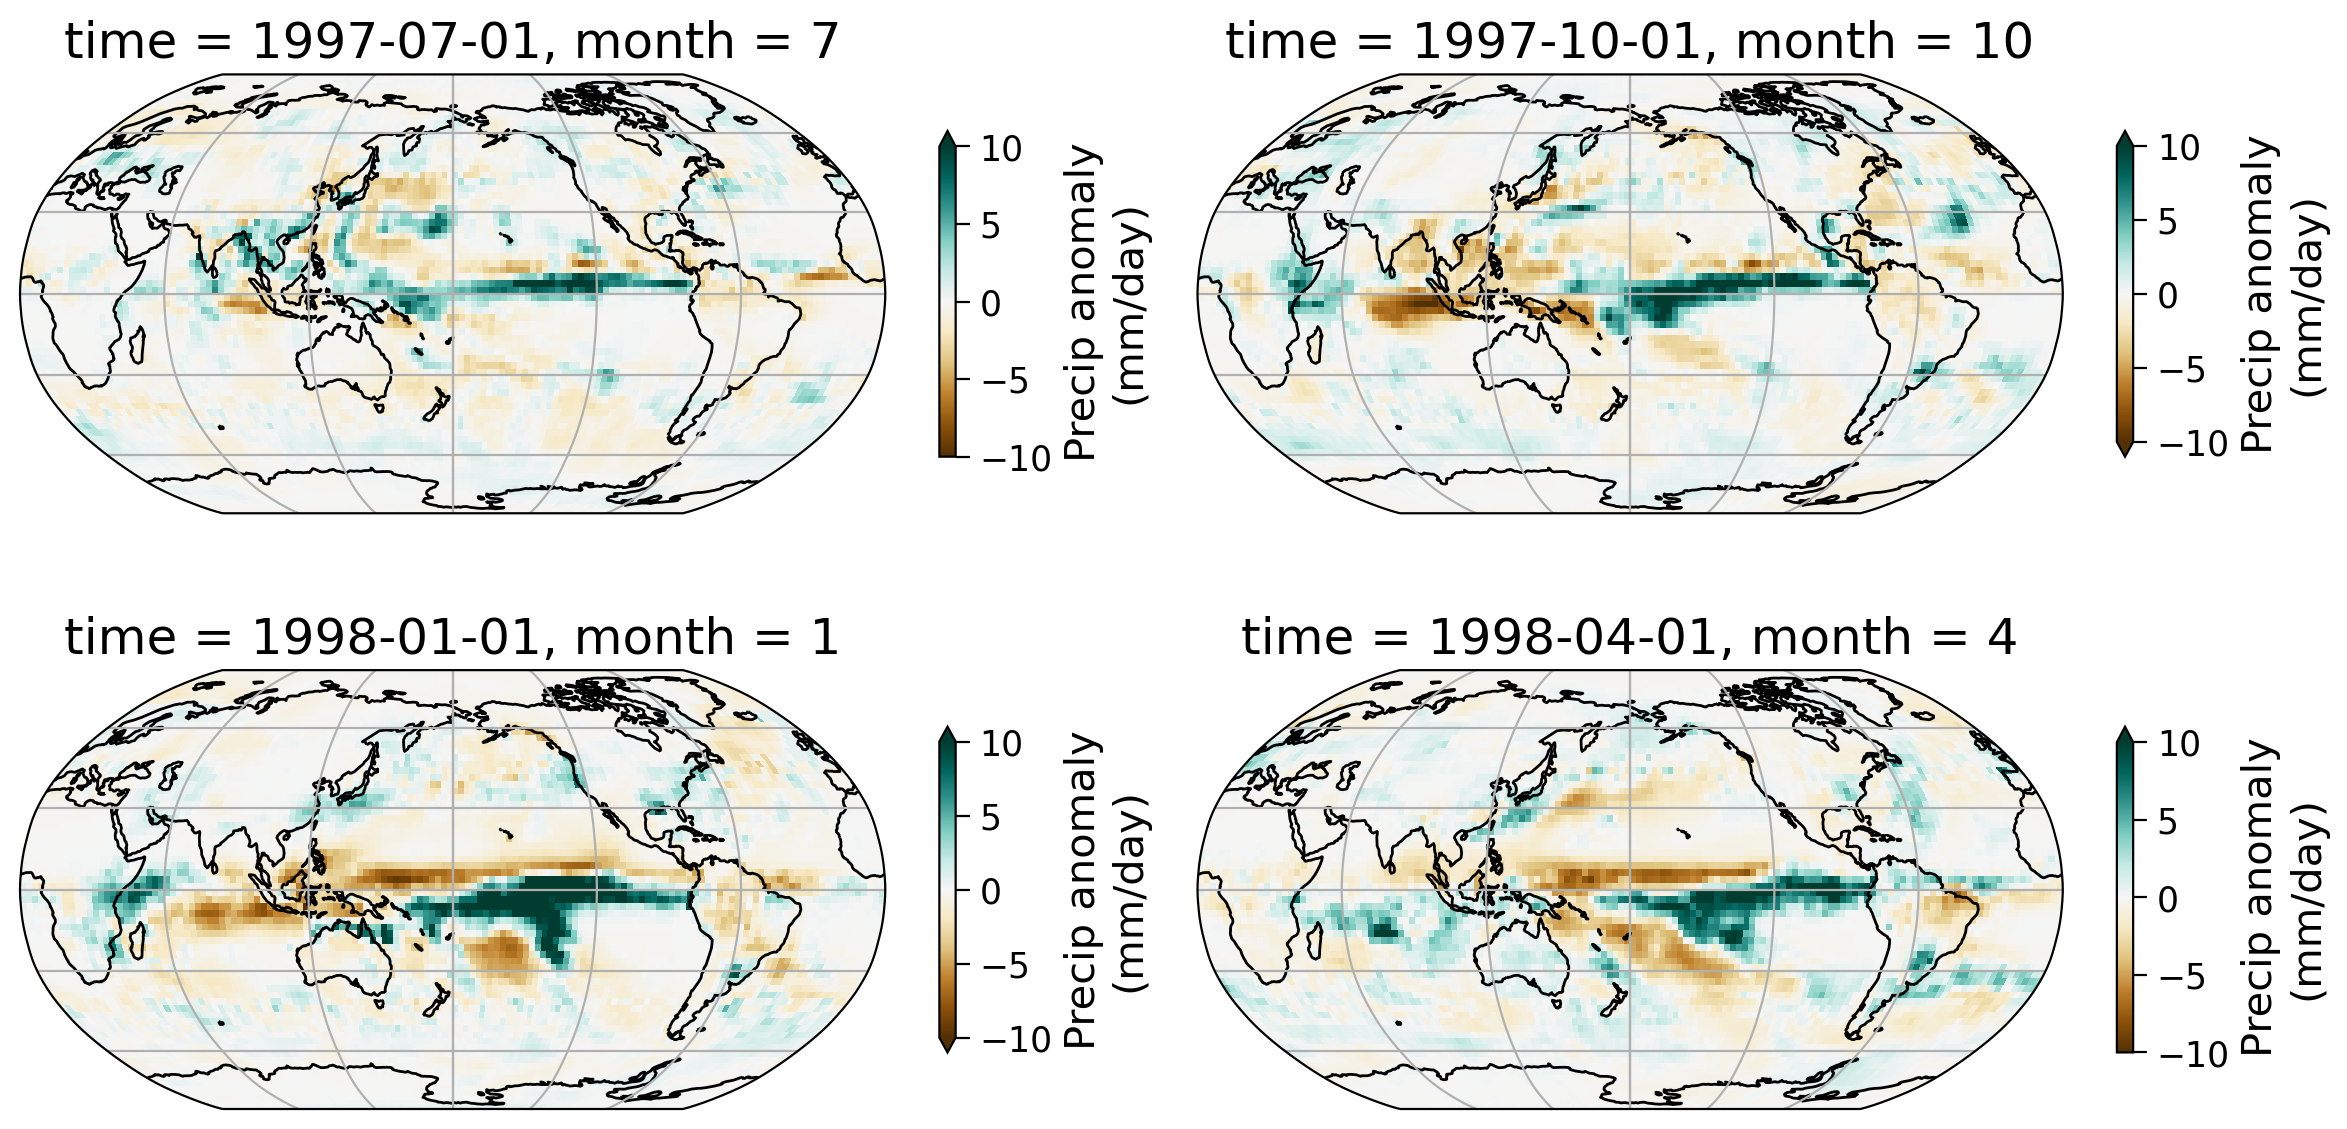

In [32]:
# define the figure and each axis for the 2 rows and 2 columns
fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    subplot_kw={"projection": ccrs.Robinson(central_longitude=180)},
    figsize=(12, 7.5),
    sharex=True,
    sharey=True,
)

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs = axs.flatten()

# loop over selected months (Jan, Apr, Jul, Oct)
for i, month in enumerate(["1997-07-01", "1997-10-01", "1998-01-01", "1998-04-01"]):

    # draw the coastines and major gridline for each subplot
    axs[i].coastlines()
    axs[i].gridlines()

    # draw the precipitation anomaly data
    precip.precip.sel(time=month).plot(
        ax=axs[i],
        transform=ccrs.PlateCarree(),
        vmin=-10,
        vmax=10,  # use the same range of max and min value
        cmap="BrBG",
        cbar_kwargs=dict(shrink=0.4, label="Precip anomaly\n(mm/day)"),
    )

In this series of four monthly maps, notice the shifts in precipitation patterns across the tropics and various land regions.

In particular there are large increases and decreases in precipitation over the tropical ocean, where ENSO is actively monitored. In the Nino 3.4 region, the intensification of the El Niño phase from  (which is characterized by warmer SSTs over the central and eastern Pacific) occurs alongside an increase in rainfall shown here (more blue ares near the equator).

In addition to these changes, there are also rainfall patterns in regions such as in North and South America, with the Amazon as a notable example. 

# Section 2: Correlation Analysis

Beyond visual inspection, we can also quantify the correlation between the ENSO (ONI) and the precipitation anomaly for a region of our interest.

Let's use Niño 3.4 region as an example to calculate the correlation berween precipitation and ONI.

In [33]:
# extract precipitation data for the Nino 3.4 region & the same time period with ONI data
precip_nino34 = precip.sel(
    latitude=slice(-5, 5),
    longitude=slice(190, 240),
    time=slice("1981-09-01", "2022-12-01"),
)
precip_nino34

<xarray.Dataset>
Dimensions:    (time: 496, latitude: 4, longitude: 20)
Coordinates:
  * time       (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2022-12-01
    month      (time) int32 ...
  * longitude  (longitude) float32 191.2 193.8 196.2 198.8 ... 233.8 236.2 238.8
  * latitude   (latitude) float32 -3.75 -1.25 1.25 3.75
Data variables:
    precip     (time, latitude, longitude) float32 ...

In [34]:
# calculate regional mean of the precipitation anomaly
precip_nino34_mean = precip_nino34.mean(("latitude", "longitude"))

# extract ONI value for the common period (ending at 2022-12-01)
nino34 = oni.sel(time=slice("1981-09-01", "2022-12-01"))

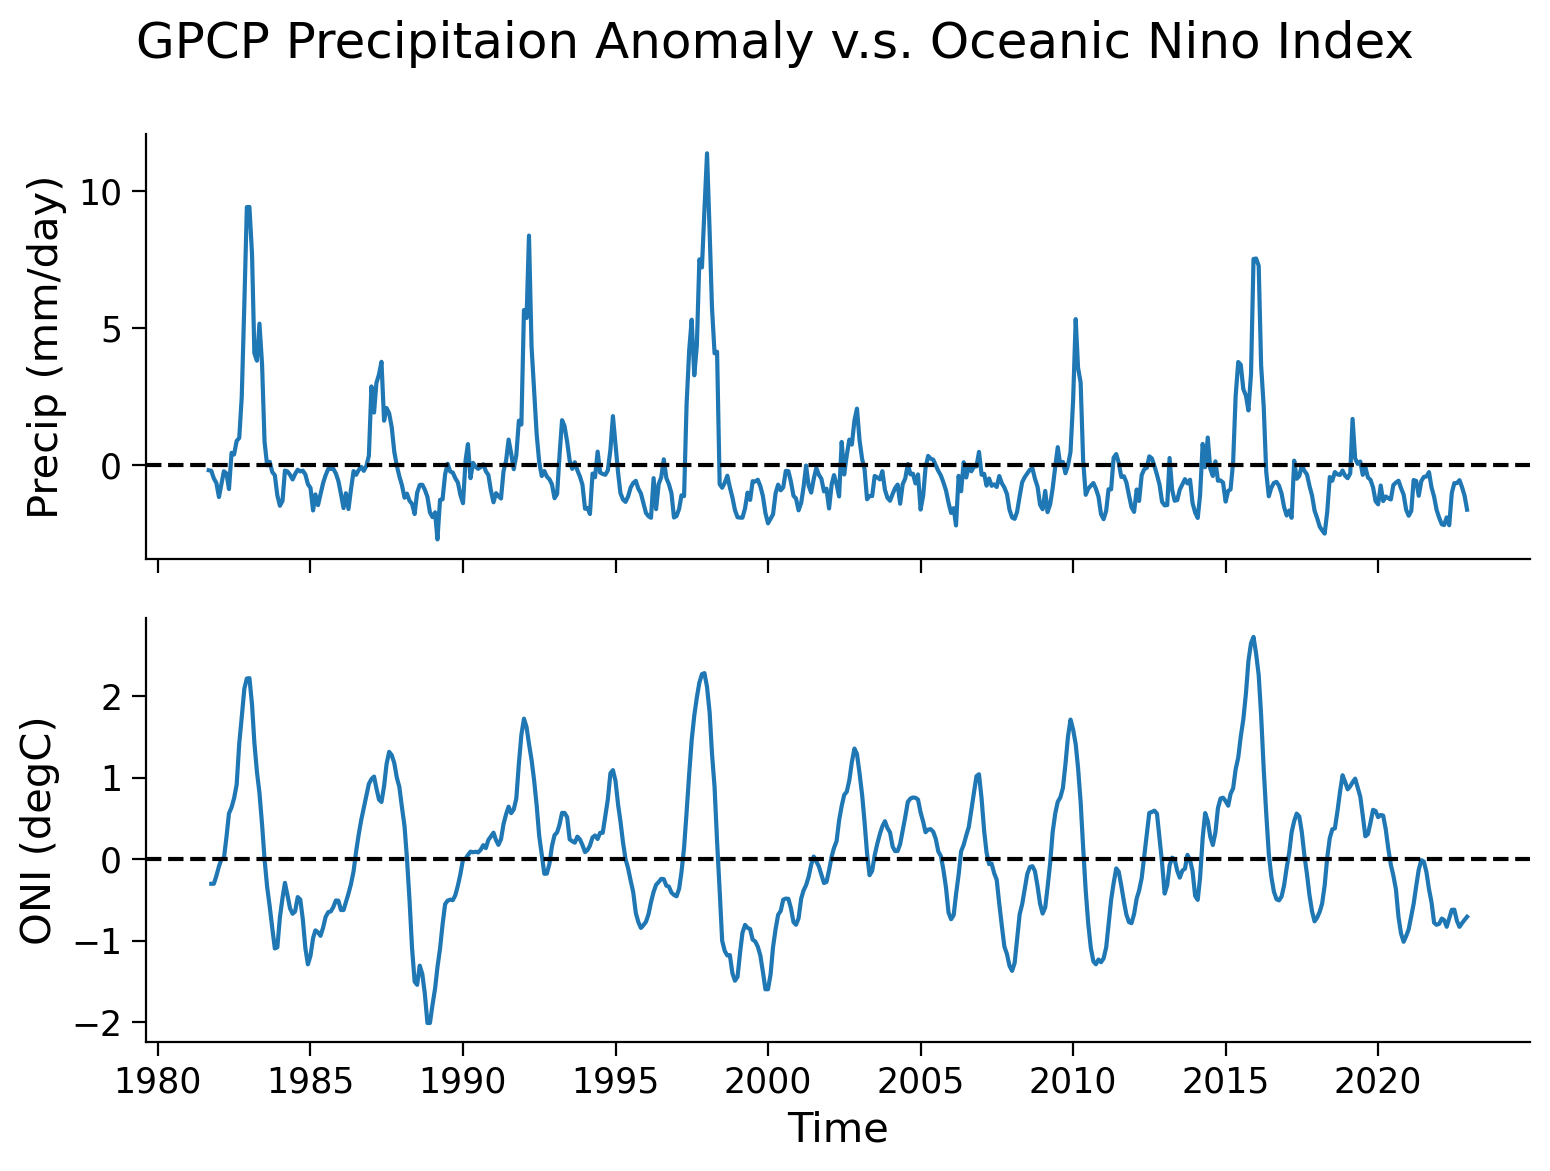

In [35]:
# set up two subplots that share the x-axis to compare precipitation anomaly and ONI index
fig, axs = plt.subplots(2, sharex=True)
fig.suptitle("GPCP Precipitaion Anomaly v.s. Oceanic Nino Index")
axs[0].plot(precip_nino34_mean.time, precip_nino34_mean.precip)
axs[0].set_ylabel("Precip (mm/day)")
axs[0].axhline(y=0, color="k", linestyle="dashed")
axs[1].plot(nino34.time, nino34.sst)
axs[1].set_ylabel("ONI (degC)")
axs[1].set_xlabel("Time")
axs[1].axhline(y=0, color="k", linestyle="dashed")

From theses two time series, a pattern exists of a synchronized change in the precipitation anomaly and ONI. Now, we can generate a scatter plot to further examine this relationship.

Text(0, 0.5, 'Precipitation Anomaly (mm/day)')

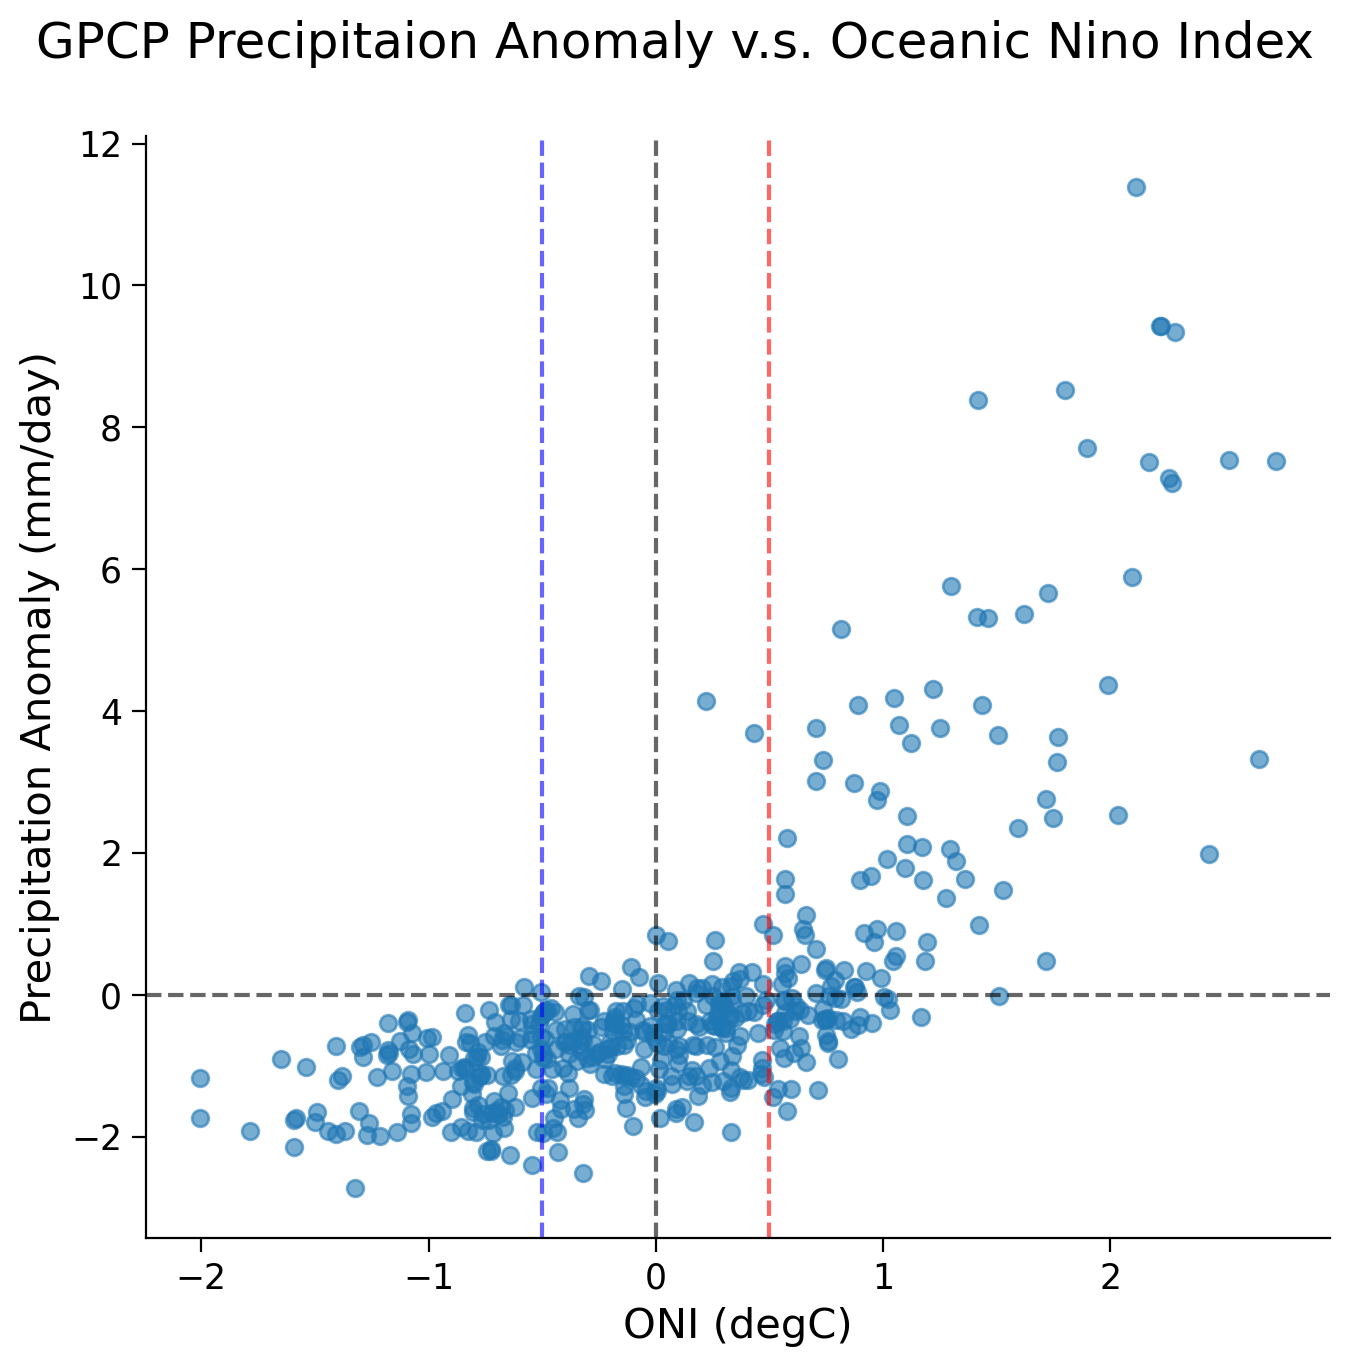

In [36]:
# set up scatter plot
fig, ax = plt.subplots(figsize=(7, 7))
fig.suptitle("GPCP Precipitaion Anomaly v.s. Oceanic Nino Index")
ax.scatter(nino34.sst, precip_nino34_mean.precip, alpha=0.6)

# add horizontal and vertical lines of 0 values
ax.axhline(y=0, linestyle="dashed", color="k", alpha=0.6)
ax.axvline(x=0, linestyle="dashed", color="k", alpha=0.6)
ax.axvline(x=0.5, linestyle="dashed", color="r", alpha=0.6)  # El Nino threshold
ax.axvline(x=-0.5, linestyle="dashed", color="b", alpha=0.6)  # La Nina threshold
ax.set_xlabel("ONI (degC)")
ax.set_ylabel("Precipitation Anomaly (mm/day)")

The scatter plot unveils a nonlinear relationship between precipitation anomalies and the ONI across different ENSO phases:

- During the La Niña phase (i.e., when ONI values fall below -0.5/ the blue line), the Niño 3.4 region typically experiences below-average precipitation.
- In contrast, during the El Niño phase (i.e., when ONI values rise above 0.5/ the red line), the Nino 3.4 region is inclined towards above-average precipitation.

Although the overall relationship is nonlinear, we are only interested in the data during different ENSO phases (ONI above and below 0.5). Looking at this data separately, visually a linear fit seems appropriate. For your projects, you should check this is so by looking at the distribution of the **residuals of the linear fit**. The residuals are the difference between a dataset predicted by the linear model you will find during the regression process and the true data. If the fit is good, there should be no relationship between these two (i.e. the distribution of residuals should have little to no correlation with your data. For simplicity, we skip this step here.

After you separate our data, you can look at the correlation coefficient and the associated p-value. This tells us how strongly related changes in the ONI are related to changes in precipitatoin anomalies. It is a value between -1 and 1, where the sign indicates whether the relationship is positive or negative, and the the absolute value tells us how strong the correlation. An absolute value of the correlatin coefficient closer to 1 indicates a stronger correlation. A low p-value will then assure us that likelihood of the correlation we find being purely due to chance is very low.

First let us separate our data into El Niño and La Niña phases by using the ONI as a threshold.

In [37]:
# El Nino Data, logically index to keep ONI values above 0.5
el_nino_sst = nino34.sst[nino34.sst > 0.5]
el_nino_precip = precip_nino34_mean.precip[nino34.sst > 0.5]

# La Nina Data, logically index to keep ONI values below -0.5
la_nina_sst = nino34.sst[nino34.sst < -0.5]
la_nina_precip = precip_nino34_mean.precip[nino34.sst < -0.5]

Text(0, 0.5, 'Precipitation Anomaly (mm/day)')

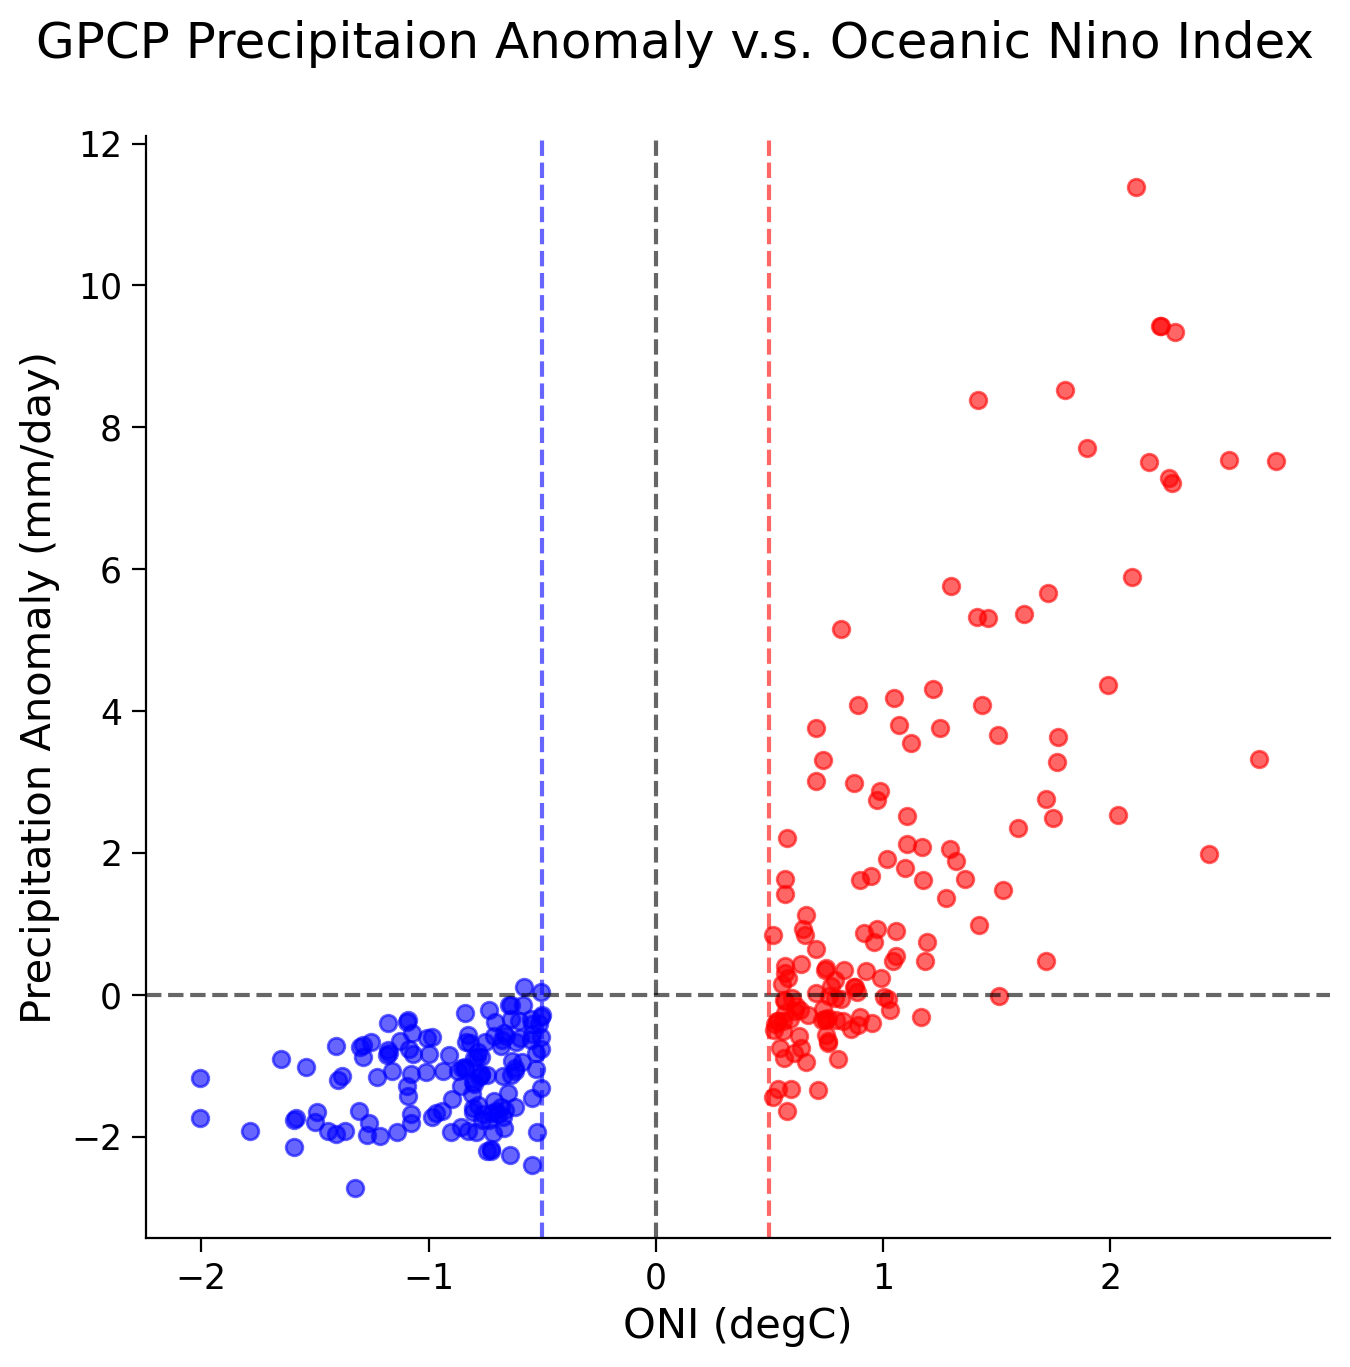

In [38]:
# set up scatter plot for just El Nino and La Nina phases
fig, ax = plt.subplots(figsize=(7, 7))
fig.suptitle("GPCP Precipitaion Anomaly v.s. Oceanic Nino Index")
ax.scatter(el_nino_sst, el_nino_precip, c="r", alpha=0.6)
ax.scatter(la_nina_sst, la_nina_precip, c="b", alpha=0.6)

# add horizontal and vertical lines of 0 values
ax.axhline(y=0, linestyle="dashed", color="k", alpha=0.6)
ax.axvline(x=0, linestyle="dashed", color="k", alpha=0.6)
ax.axvline(x=0.5, linestyle="dashed", color="r", alpha=0.6)  # El Nino threshold
ax.axvline(x=-0.5, linestyle="dashed", color="b", alpha=0.6)  # La Nina threshold
ax.set_xlabel("ONI (degC)")
ax.set_ylabel("Precipitation Anomaly (mm/day)")

Now find the linear correlation coefficient using [SciPy stats package](https://docs.scipy.org/doc/scipy/tutorial/stats.html).

In [39]:
# correlation for El Nino data
el_nino_r, el_nino_p = stats.pearsonr(el_nino_sst, el_nino_precip)

print("El Nino - Corr Coef: " + str(el_nino_r) + ", p-val: " + str(el_nino_p))

# correlation for La Nina data
la_nina_r, la_nina_p = stats.pearsonr(la_nina_sst, la_nina_precip)

print("La Nina - Corr Coef: " + str(la_nina_r) + ", p-val: " + str(la_nina_p))

El Nino - Corr Coef: 0.7761810196258422, p-val: 5.01738976537403e-29
La Nina - Corr Coef: 0.2779193033452745, p-val: 0.0010531198995347153


## **Questions 2: Climate Connection**

1. Note that the correlation during La Niña phases is low with a higher p-value (less significant) than the correlation coefficient during El Niño phases. Explain what this means.
2. Do the differences in correlation coefficients between phases line up with the time series above? Explain why.

In [40]:
# to_remove explanation

'''
1. The low correlation between the La Niña phase as precipitation suggests that there is not a strong relationship between the two. However, the stronger and significant correlation between El Niño and precipitation anomalies suggests that there is a more robust relationship between the two. This is in keeping with our physical understanding of how atmospheric convection and therefore preciptiation are affected that we learned about in Day 2.
2. It does. In the time series, we note that when there are peaks in the ONI, indicating and El Niño phase, there are generally peaks in the precipication anomaly. However, for La Niña events, when there are troughs in the ONI data, there is much less agreement with the precipitation anomalies.

''';

## Coding Exercises 2

1. Choose a region of your interest to examine the relationship between ENSO (using ONI data) and precipitation anomaly globally. It will be interesting to see if the figures you make line up with your expectations from the maps we have made in the beginning of the tutorial. Will they be more or less correlated that the Niño 3.4 region? In the example code we will use Italy, but you can change this to be whatever region you are interested in.

Text(0, 0.5, 'Precipitation Anomaly (mm/day)')

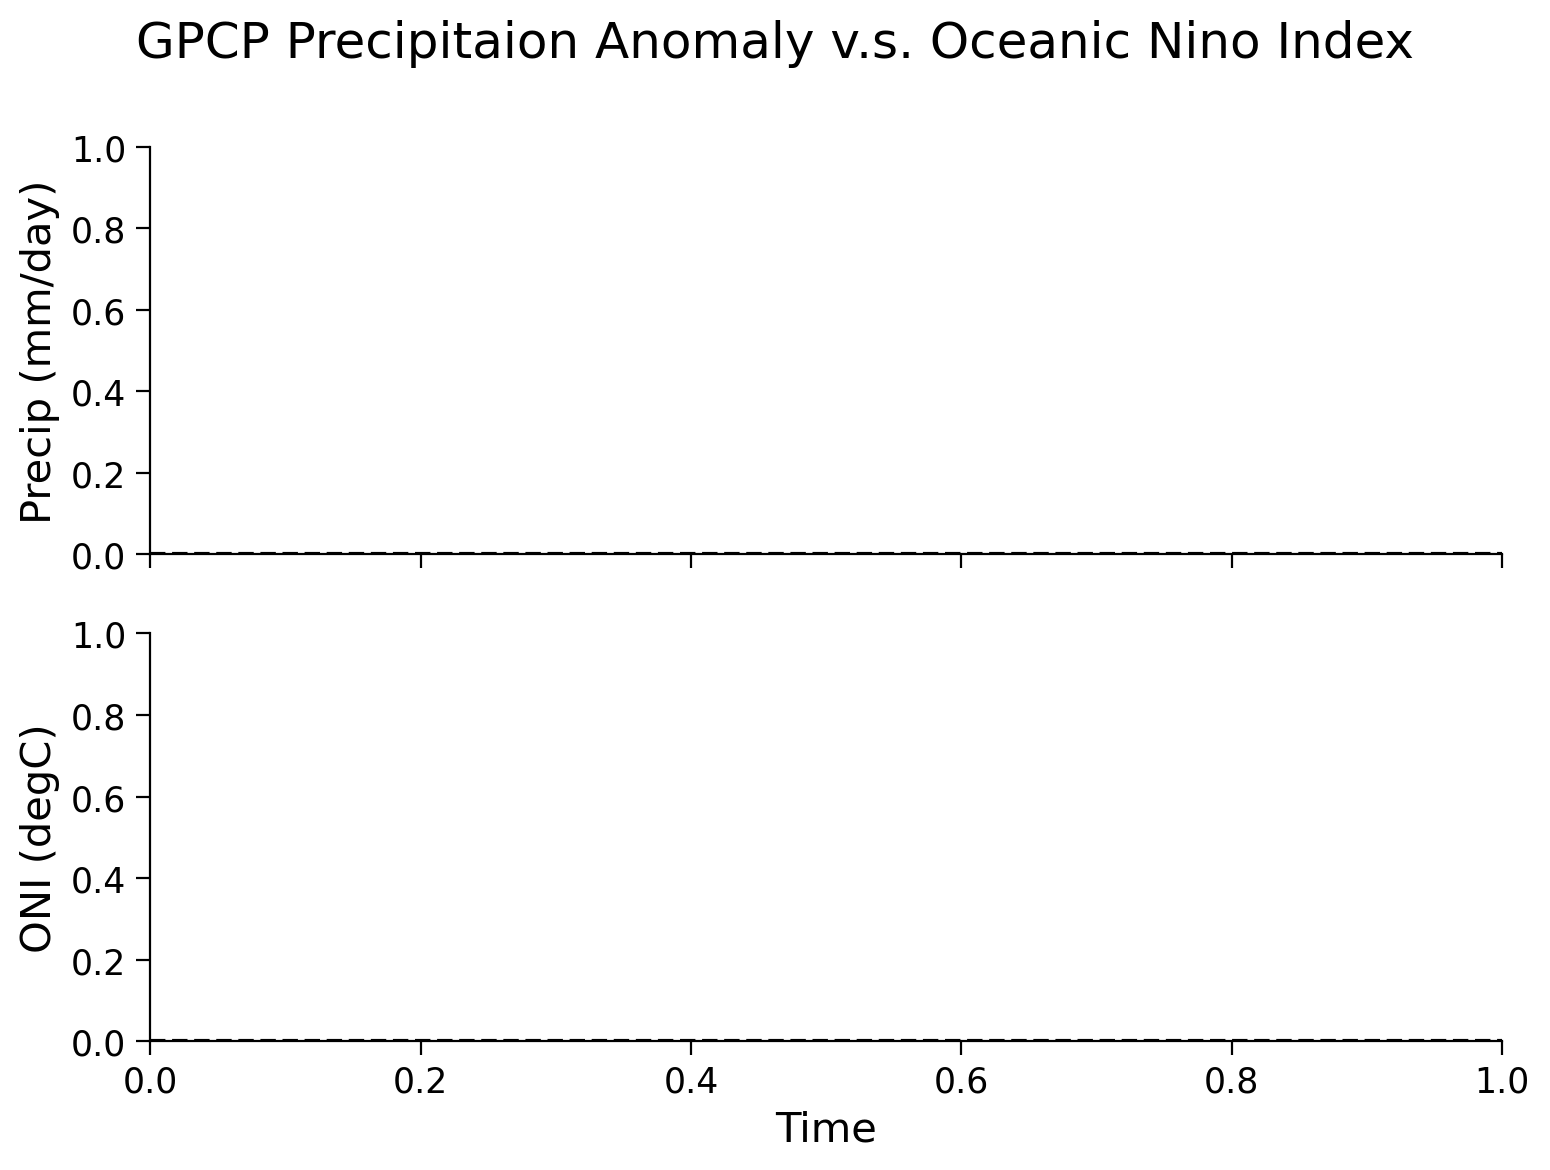

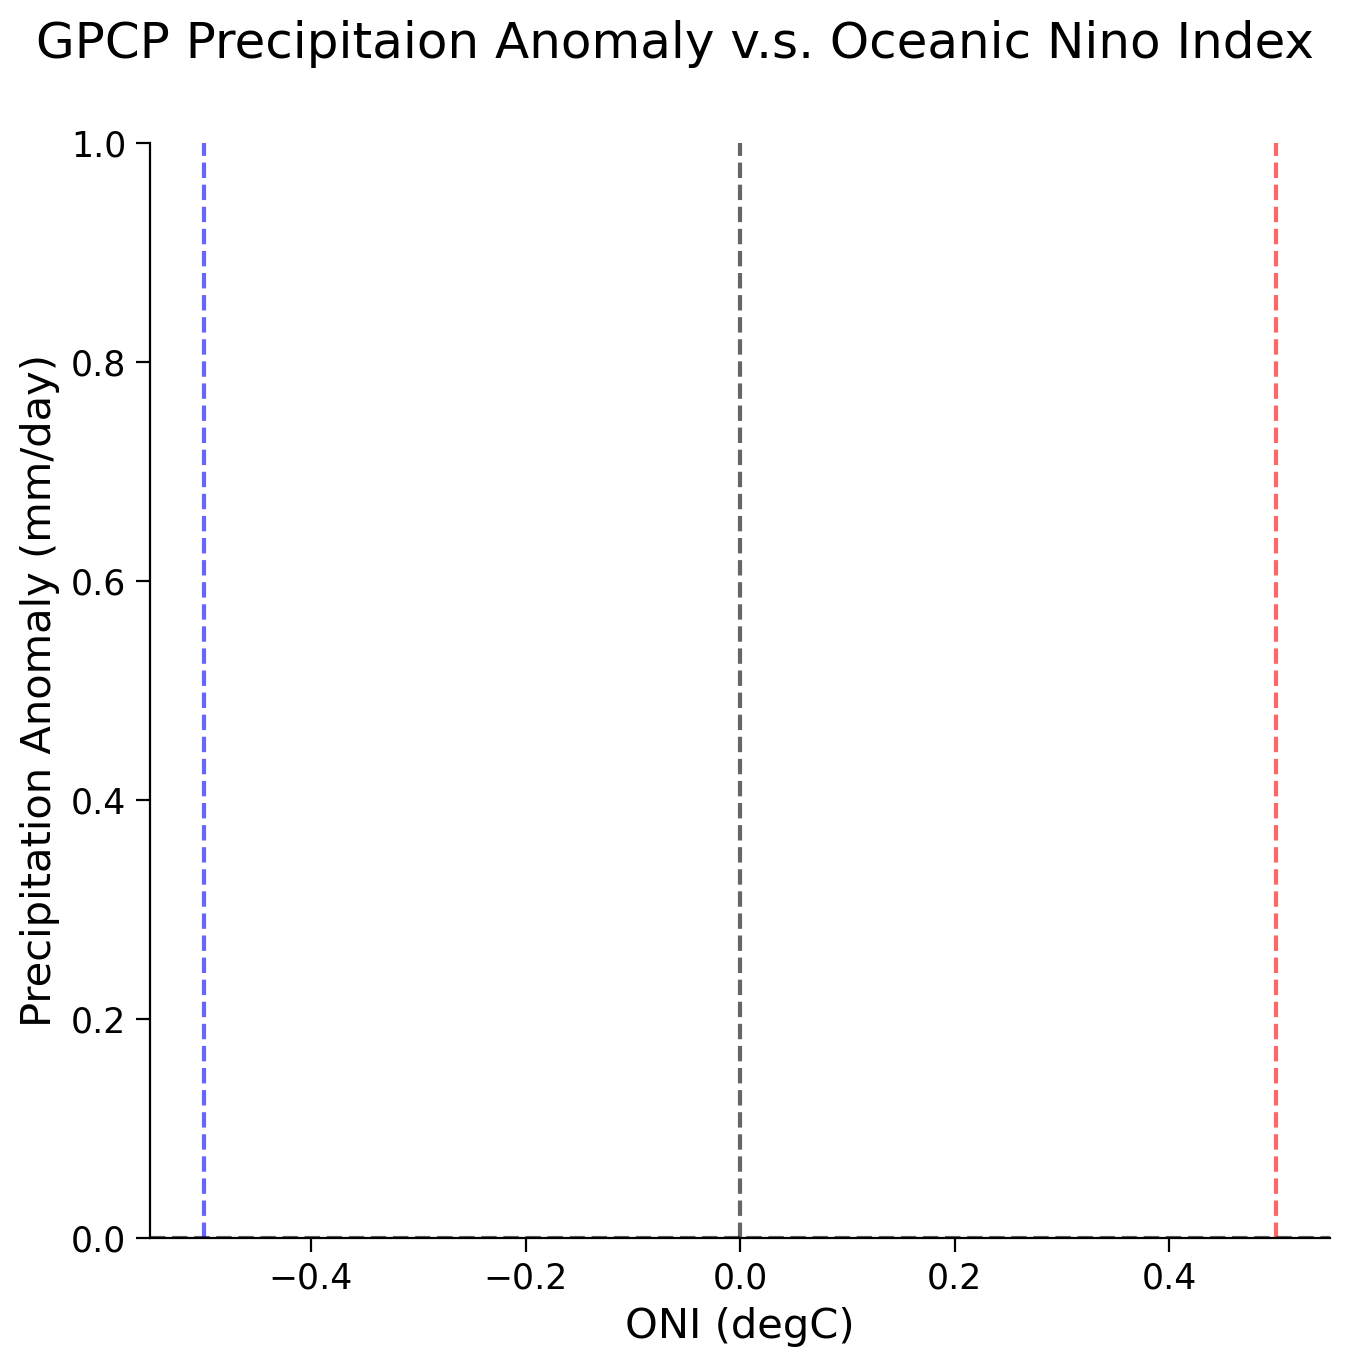

In [41]:
# define region of interest for the precipitation anomaly
italy_lon = [...]
italy_lat = [...]

# calculate regional mean time series
# precip_nino34_italy = precip.sel(
#     latitude=slice(...),
#     longitude=slice(...),
#     time=slice("1981-09-01", "2022-12-01"),
# ).mean(dim=(...))

# plot the time series of precipitation anomaly and ONI for the same time period on different subplots
fig, axs = plt.subplots(2, sharex=True)
fig.suptitle("GPCP Precipitaion Anomaly v.s. Oceanic Nino Index")
# axs[0].plot(precip_nino34_italy.time, precip_nino34_italy.precip)
axs[0].set_ylabel("Precip (mm/day)")
axs[0].axhline(y=0, color="k", linestyle="dashed")
# axs[1].plot(nino34.time, nino34.sst)
axs[1].set_ylabel("ONI (degC)")
axs[1].set_xlabel("Time")
axs[1].axhline(y=0, color="k", linestyle="dashed")

# El Nino Data, logically index to keep ONI values above 0.5
italy_el_nino_sst = ...
italy_el_nino_precip = ...

# La Nina Data, logically index to keep ONI values below -0.5
italy_la_nina_sst = ...
italy_la_nina_precip = ...

# correlation for El Nino data
# italy_el_nino_r, italy_el_nino_p = ...

# print(
#     "El Nino - Corr Coef: " + str(italy_el_nino_r) + ", p-val: " + str(italy_el_nino_p)
# )

# correlation for La Nina data
# italy_la_nina_r, italy_la_nina_p = ...

# print(
#     "La Nina - Corr Coef: " + str(italy_la_nina_r) + ", p-val: " + str(italy_la_nina_p)
# )

# plot scatter plot between precipitation and ONI
fig, ax = plt.subplots(figsize=(7, 7))
fig.suptitle("GPCP Precipitaion Anomaly v.s. Oceanic Nino Index")
# ax.scatter(italy_el_nino_sst, italy_el_nino_precip, c="r", alpha=0.6)
# ax.scatter(italy_la_nina_sst, italy_la_nina_precip, c="b", alpha=0.6)

# add horizontal and vertical lines of 0 values
ax.axhline(y=0, linestyle="dashed", color="k", alpha=0.6)
ax.axvline(x=0, linestyle="dashed", color="k", alpha=0.6)
ax.axvline(x=0.5, linestyle="dashed", color="r", alpha=0.6)  # El Nino threshold
ax.axvline(x=-0.5, linestyle="dashed", color="b", alpha=0.6)  # La Nina threshold
ax.set_xlabel("ONI (degC)")
ax.set_ylabel("Precipitation Anomaly (mm/day)")

El Nino - Corr Coef: -0.020174744868327973, p-val: 0.814311374404942
La Nina - Corr Coef: 0.2339975971792704, p-val: 0.006109555243286934


Text(0, 0.5, 'Precipitation Anomaly (mm/day)')

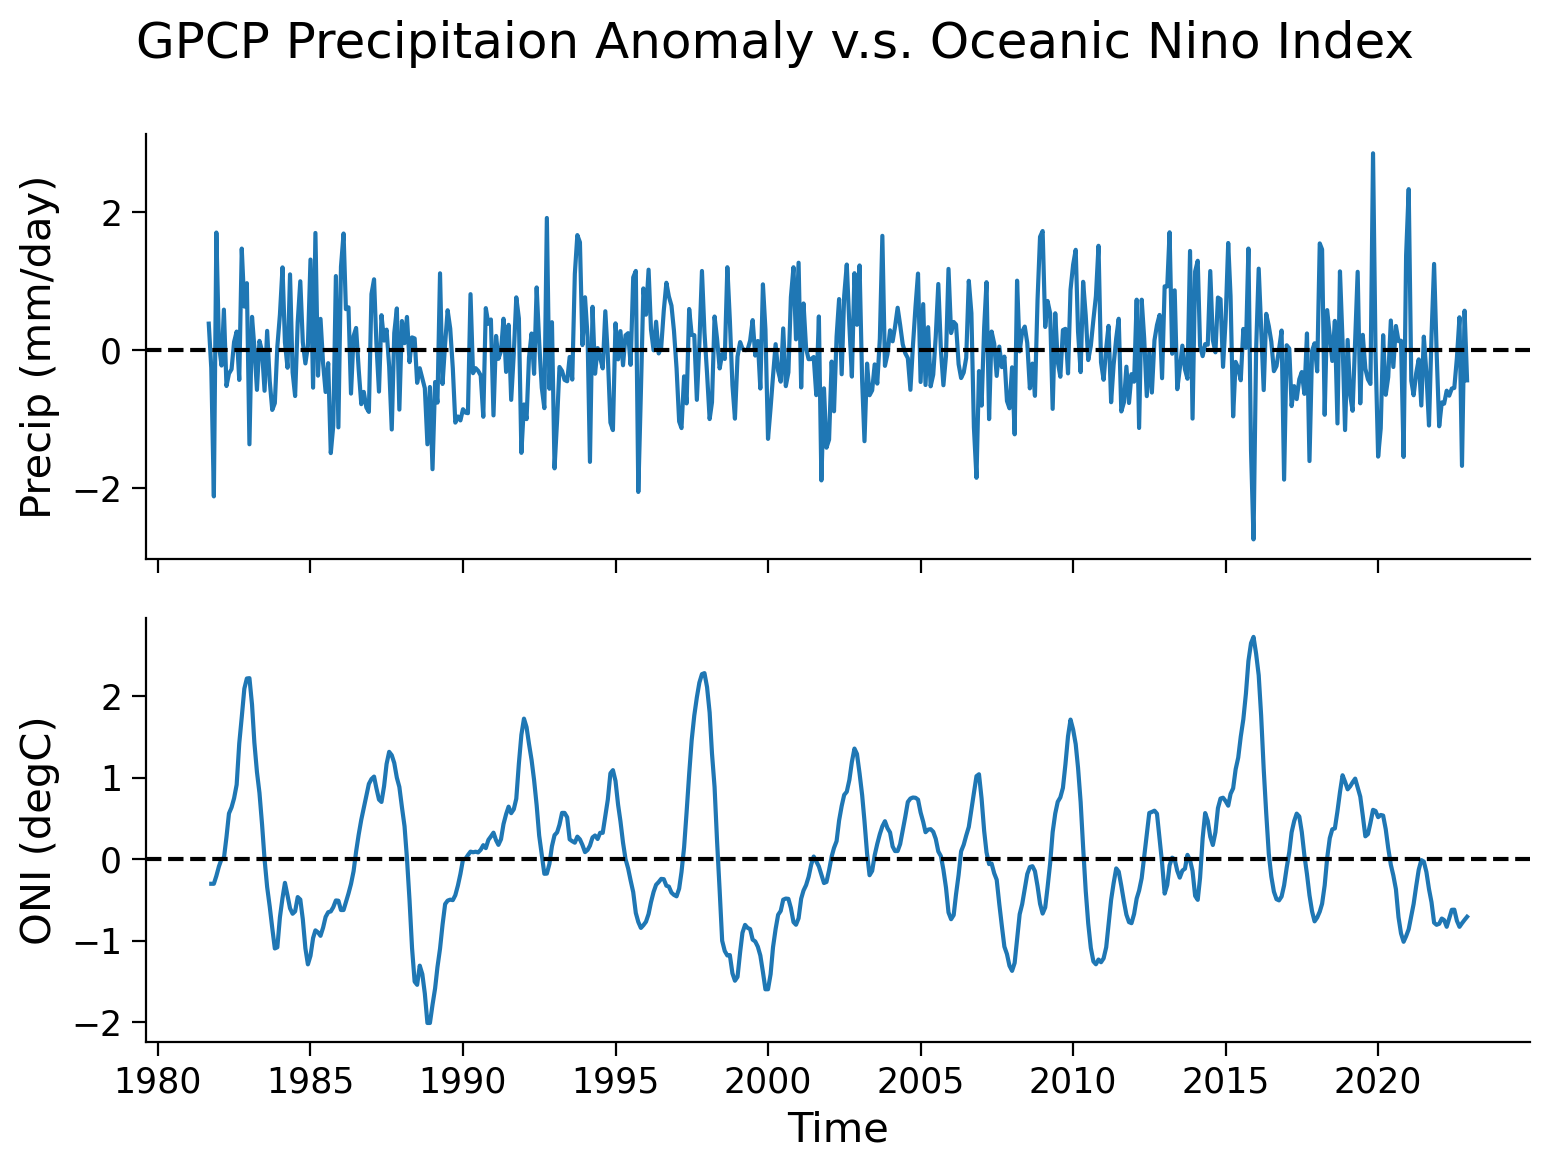

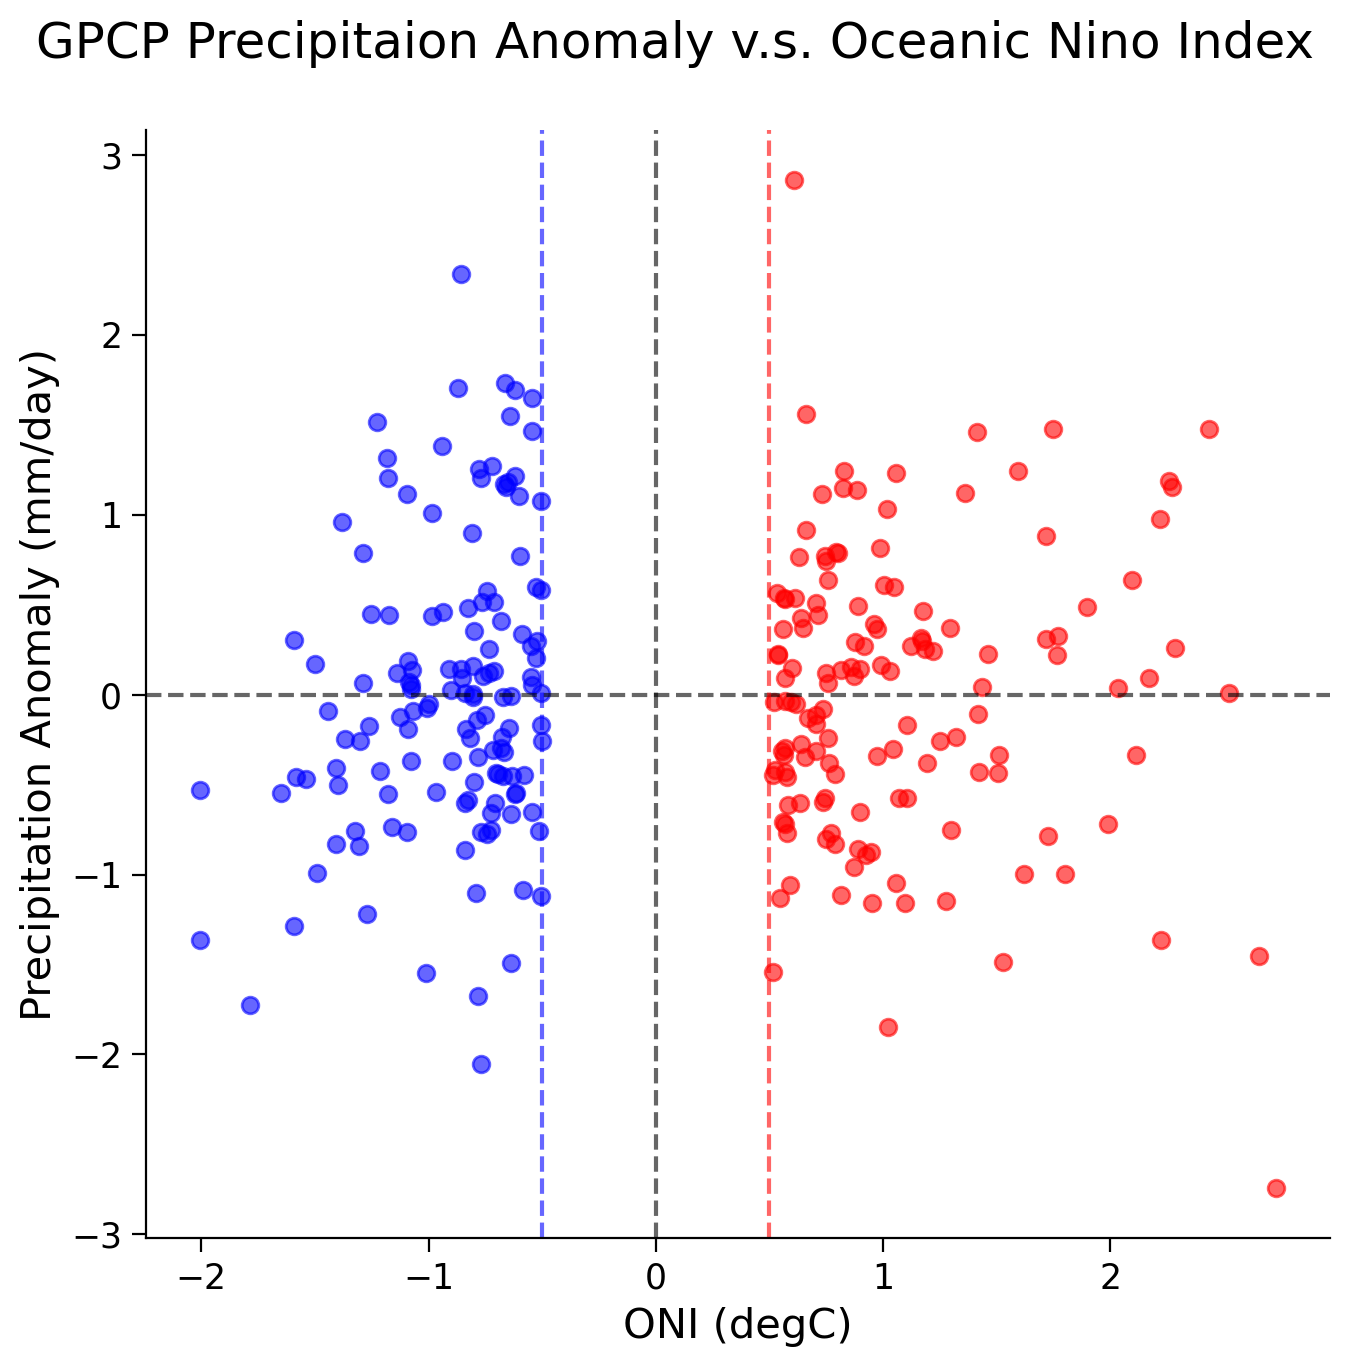

In [42]:
# to_remove solution

# define region of interest for the precipitation anomaly
italy_lon = [6, 19]
italy_lat = [36, 48]

# calculate regional mean time series
precip_nino34_italy = precip.sel(
    latitude=slice(italy_lat[0], italy_lat[1]),
    longitude=slice(italy_lon[0], italy_lon[1]),
    time=slice("1981-09-01", "2022-12-01"),
).mean(dim=("latitude", "longitude"))

# plot the time series of precipitation anomaly and ONI for the same time period on different subplots
fig, axs = plt.subplots(2, sharex=True)
fig.suptitle("GPCP Precipitaion Anomaly v.s. Oceanic Nino Index")
axs[0].plot(precip_nino34_italy.time, precip_nino34_italy.precip)
axs[0].set_ylabel("Precip (mm/day)")
axs[0].axhline(y=0, color="k", linestyle="dashed")
axs[1].plot(nino34.time, nino34.sst)
axs[1].set_ylabel("ONI (degC)")
axs[1].set_xlabel("Time")
axs[1].axhline(y=0, color="k", linestyle="dashed")

# El Nino Data, logically index to keep ONI values above 0.5
italy_el_nino_sst = nino34.sst[nino34.sst > 0.5]
italy_el_nino_precip = precip_nino34_italy.precip[nino34.sst > 0.5]

# La Nina Data, logically index to keep ONI values below -0.5
italy_la_nina_sst = nino34.sst[nino34.sst < -0.5]
italy_la_nina_precip = precip_nino34_italy.precip[nino34.sst < -0.5]

# correlation for El Nino data
italy_el_nino_r, italy_el_nino_p = stats.pearsonr(
    italy_el_nino_sst, italy_el_nino_precip
)

print(
    "El Nino - Corr Coef: " + str(italy_el_nino_r) + ", p-val: " + str(italy_el_nino_p)
)

# correlation for La Nina data
italy_la_nina_r, italy_la_nina_p = stats.pearsonr(
    italy_la_nina_sst, italy_la_nina_precip
)

print(
    "La Nina - Corr Coef: " + str(italy_la_nina_r) + ", p-val: " + str(italy_la_nina_p)
)

# plot scatter plot between precipitation and ONI
fig, ax = plt.subplots(figsize=(7, 7))
fig.suptitle("GPCP Precipitaion Anomaly v.s. Oceanic Nino Index")
ax.scatter(italy_el_nino_sst, italy_el_nino_precip, c="r", alpha=0.6)
ax.scatter(italy_la_nina_sst, italy_la_nina_precip, c="b", alpha=0.6)

# add horizontal and vertical lines of 0 values
ax.axhline(y=0, linestyle="dashed", color="k", alpha=0.6)
ax.axvline(x=0, linestyle="dashed", color="k", alpha=0.6)
ax.axvline(x=0.5, linestyle="dashed", color="r", alpha=0.6)  # El Nino threshold
ax.axvline(x=-0.5, linestyle="dashed", color="b", alpha=0.6)  # La Nina threshold
ax.set_xlabel("ONI (degC)")
ax.set_ylabel("Precipitation Anomaly (mm/day)")

# Summary
In this tutorial, you've acquired skills to evaluate the connection between precipitation and large-scale climate variability by analyzing the Oceanic Nino Index (ONI) and precipitation data.

- You've discovered that the during ENSO, precipitation patterns in the tropics are altered.
- You have used Pearson's correlation coefficient to investigate potential correlations. However, it's critical to further scrutinize these correlations with physical explanations to ensure that any detected signals are valid.


# Resources

Data from this tutorial can be accessed for OISST [here](https://www.ncei.noaa.gov/products/optimum-interpolation-sst) and precipitation [here](https://noaa-cdr-precip-gpcp-monthly-pds.s3.amazonaws.com/index.html#data/).